# This notebook will make use of insights from the previous part to populate ML models.

## Preprocessing the data

In [0]:
# Imports
import math
import operator
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [0]:
# PATHS

origination_path = "origination_sample.csv"
update_path = "update_sample.csv"

In [3]:
# Set up pandas dataframes
orig_df = pd.read_csv(origination_path)
orig_df = orig_df.set_index('loan_sequence_number')
update_df =  pd.read_csv(update_path)
update_df =update_df.set_index('loan_sequence_number')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,7,14,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Lets add the field "Year" to both the dataframes

In [0]:
orig_df.insert(2, "Year", value=orig_df["first_payment_date"].floordiv(100))
update_df.insert(2, "Year", update_df["monthly_reporting_period"].floordiv(100))

Now let's set up the training and testing sets.

We should first figure out what we want to predict:   Propensity to Repurchase

Well, based on previous insights we have a few features that we're interested in:


1.   First-time homebuyer flag
2.   Source of Origination
3.   Property State
4.   Original LTV
5.   CLTV
6.   Current DTI
7.   Change in IR
8.   Current Credit Score
9.   Loan Age
10.  Months To Maturity
11. Year
12. Current UPB

For predicting default, we should be predicting:
Zero-Balance Code of (Not 1.0 or 2.0)

For predicting repurchase, we should be predicting:
Repurchase Flag = 'Y'



In [0]:
update_filtered_df = update_df.filter(["loan_sequence_number", "Year", "current_actual_upb", "months_to_maturity", "repurchase_flag", "zero_balance_code", "current_interest_rate"])

In [6]:
update_df.dtypes

monthly_reporting_period            int64
current_actual_upb                float64
Year                                int64
current_lds                        object
loan_age                            int64
months_to_maturity                  int64
repurchase_flag                    object
modification_flag                  object
zero_balance_code                 float64
zero_balance_date                 float64
current_interest_rate             float64
current_deffered_upb              float64
ddlpi                             float64
mi_recoveries                     float64
net_sales_proceeds                 object
non_mi_recoveries                 float64
expenses                          float64
legal_costs                       float64
maintenance_preservation_costs    float64
taxes_insurance                   float64
misc_expenses                     float64
actual_loss_calculation           float64
modification_cost                 float64
step_modification_flag            

In [7]:
update_filtered_df.dtypes

Year                       int64
current_actual_upb       float64
months_to_maturity         int64
repurchase_flag           object
zero_balance_code        float64
current_interest_rate    float64
dtype: object

In [0]:
# removing intermediate values
update_filtered_df = update_filtered_df[update_filtered_df["zero_balance_code"] >= 1.0]

In [9]:
update_filtered_df

,Year,current_actual_upb,months_to_maturity,repurchase_flag,zero_balance_code,current_interest_rate
loan_sequence_number,,,,,,
F104Q2011766,2012,0.0,262,N,1.0,5.900
F101Q3333372,2014,0.0,207,N,1.0,7.750
F105Q2318868,2018,0.0,206,N,2.0,6.690
F104Q3012269,2011,0.0,282,N,1.0,6.480
F104Q4001084,2011,0.0,277,N,1.0,5.690
...,...,...,...,...,...,...
F106Q1249353,2011,0.0,295,N,3.0,7.375
F108Q4039866,2014,0.0,294,N,1.0,7.375
F107Q3059569,2013,0.0,293,N,1.0,7.375


We need a default column to predict!

In [0]:
#adding defaulted column
update_filtered_df.insert(1, "defaulted", 0)

In [11]:
# actually implementing defaulted (zero_balance_code > 2.0)
for loan in update_filtered_df.index:

  code = update_filtered_df["zero_balance_code"].loc[loan]
  if code > 2.0:
    update_filtered_df["defaulted"].loc[loan] = 1
  

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
update_filtered_df.sample(10)

,Year,defaulted,current_actual_upb,months_to_maturity,repurchase_flag,zero_balance_code,current_interest_rate
loan_sequence_number,,,,,,,
F103Q3601312,2011,0,0.0,272,N,1.0,6.250
F104Q2175461,2012,0,0.0,264,N,1.0,5.375
F112Q1113521,2013,0,0.0,347,N,1.0,4.125
F109Q1019189,2011,0,0.0,329,N,1.0,5.125
F109Q1421935,2013,0,0.0,311,N,1.0,4.875
F105Q3449410,2010,0,0.0,181,N,1.0,6.375
F109Q4333951,2011,0,0.0,159,N,1.0,4.750
F109Q2072856,2010,0,0.0,344,N,1.0,5.125
F106Q4302606,2014,0,0.0,90,N,1.0,6.000


In [0]:
#adding original interest rate
update_filtered_df = update_filtered_df.merge(orig_df["original_rate"], how='inner', left_index=True, right_index=True)

In [0]:
# inserting changed interest rate
update_filtered_df.insert(8, "changed_rate", update_filtered_df["current_interest_rate"].subtract(update_filtered_df['original_rate']))

In [0]:
# round off the values to 3 dp
update_filtered_df["changed_rate"] = update_filtered_df["changed_rate"].round(3)

In [16]:
update_filtered_df["changed_rate"].value_counts().sort_index()

-9.125        2
-8.875        2
-8.750        1
-8.625        1
-8.375        5
          ...  
-0.375        8
-0.250        3
-0.125        2
-0.000    40100
 0.125        2
Name: changed_rate, Length: 86, dtype: int64

Now lets insert credit score, first_home, property_state, channel.

In [0]:
update_filtered_df = update_filtered_df.merge(orig_df["credit_score"], how='inner', left_index=True, right_index=True)
update_filtered_df = update_filtered_df.merge(orig_df["first_time_homebuyer_flag"], how='inner', left_index=True, right_index=True)
update_filtered_df = update_filtered_df.merge(orig_df["property_state"], how='inner', left_index=True, right_index=True)
update_filtered_df = update_filtered_df.merge(orig_df["channel"], how='inner', left_index=True, right_index=True)
update_filtered_df = update_filtered_df.merge(orig_df["dti_ratio"], how='inner', left_index=True, right_index=True)


In [18]:
update_filtered_df.sample(10)

,Year,defaulted,current_actual_upb,months_to_maturity,repurchase_flag,zero_balance_code,current_interest_rate,original_rate,changed_rate,credit_score,first_time_homebuyer_flag,property_state,channel,dti_ratio
loan_sequence_number,,,,,,,,,,,,,,
F108Q2231556,2013,0,0.0,305,N,1.0,6.625,6.625,0.0,682,Y,TN,R,36
F103Q3256316,2011,0,0.0,264,N,1.0,5.375,5.375,0.0,756,9,NY,R,26
F105Q3153291,2011,0,0.0,290,N,1.0,5.875,5.875,0.0,803,N,VA,T,49
F106Q4190775,2013,0,0.0,279,N,1.0,5.875,5.875,0.0,744,9,WA,T,33
F110Q3021679,2014,0,0.0,314,N,1.0,5.625,5.625,0.0,746,9,OR,R,37
F108Q1382410,2012,0,0.0,135,N,1.0,5.375,5.375,0.0,773,9,NE,R,27
F113Q2338736,2018,0,0.0,121,N,1.0,2.875,2.875,0.0,725,9,TX,C,26
F116Q2138161,2018,0,0.0,336,N,1.0,3.750,3.750,0.0,772,Y,NM,C,29
F111Q3036320,2012,0,0.0,344,N,1.0,4.500,4.500,0.0,807,Y,TN,R,19


Great! Now we have all the fields of data necessary.

## Now is when we should start splitting up the dataset into train/test data for our different models. 

First, we're going to split up the data into repurchase_model_df 

In [0]:
#Create the dataframe used for the model data
repurchase_model_df = update_filtered_df.copy()

In [20]:
repurchase_model_df

,Year,defaulted,current_actual_upb,months_to_maturity,repurchase_flag,zero_balance_code,current_interest_rate,original_rate,changed_rate,credit_score,first_time_homebuyer_flag,property_state,channel,dti_ratio
loan_sequence_number,,,,,,,,,,,,,,
F104Q2011766,2012,0,0.0,262,N,1.0,5.900,5.900,-0.0,618,N,WI,R,42
F101Q3333372,2014,0,0.0,207,N,1.0,7.750,7.750,0.0,718,N,OH,T,999
F105Q2318868,2018,0,0.0,206,N,2.0,6.690,6.690,-0.0,681,N,VA,C,41
F104Q3012269,2011,0,0.0,282,N,1.0,6.480,6.480,-0.0,668,N,IL,R,27
F104Q4001084,2011,0,0.0,277,N,1.0,5.690,5.690,-0.0,734,N,OH,R,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F106Q1249353,2011,1,0.0,295,N,3.0,7.375,7.375,0.0,663,9,FL,R,44
F108Q4039866,2014,0,0.0,294,N,1.0,7.375,7.375,0.0,747,N,IL,C,19
F107Q3059569,2013,0,0.0,293,N,1.0,7.375,7.375,0.0,706,N,LA,T,61


In [0]:
repurchase_model_df =  repurchase_model_df.drop(labels=repurchase_model_df[repurchase_model_df["current_interest_rate"] == 0.0].index, axis="index")
repurchase_model_df =  repurchase_model_df.drop(labels=repurchase_model_df[repurchase_model_df["first_time_homebuyer_flag"] == "9"].index, axis="index")

In [22]:
repurchase_model_df

,Year,defaulted,current_actual_upb,months_to_maturity,repurchase_flag,zero_balance_code,current_interest_rate,original_rate,changed_rate,credit_score,first_time_homebuyer_flag,property_state,channel,dti_ratio
loan_sequence_number,,,,,,,,,,,,,,
F104Q2011766,2012,0,0.0,262,N,1.0,5.900,5.900,-0.0,618,N,WI,R,42
F101Q3333372,2014,0,0.0,207,N,1.0,7.750,7.750,0.0,718,N,OH,T,999
F105Q2318868,2018,0,0.0,206,N,2.0,6.690,6.690,-0.0,681,N,VA,C,41
F104Q3012269,2011,0,0.0,282,N,1.0,6.480,6.480,-0.0,668,N,IL,R,27
F104Q4001084,2011,0,0.0,277,N,1.0,5.690,5.690,-0.0,734,N,OH,R,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F108Q2214163,2013,0,0.0,299,N,1.0,7.375,7.375,0.0,635,Y,KS,T,47
F107Q4024977,2013,0,0.0,296,N,1.0,7.375,7.375,0.0,732,N,NC,R,43
F108Q4039866,2014,0,0.0,294,N,1.0,7.375,7.375,0.0,747,N,IL,C,19


In [23]:
repurchase_model_df["current_interest_rate"].value_counts().sort_index()

2.000     70
2.125      4
2.250      1
2.375      2
2.500      9
          ..
8.875      3
9.000      1
9.125      1
9.500      1
10.100     1
Name: current_interest_rate, Length: 258, dtype: int64

In [0]:
# replacing flags with numerical data 
repurchase_model_df = repurchase_model_df.drop(["defaulted", "current_interest_rate", "original_rate", "current_actual_upb"], axis=1)
repurchase_model_df["first_time_homebuyer_flag"] = repurchase_model_df["first_time_homebuyer_flag"].replace("N", 0)
repurchase_model_df["first_time_homebuyer_flag"] = repurchase_model_df["first_time_homebuyer_flag"].replace("Y", 1)


In [0]:
# replacing string columns with one-hot encoding
# repurchase_model_df["property_state"] = repurchase_model_df.drop("property_state", axis=1)

repurchase_model_df.insert(10, "retail_flag", repurchase_model_df["channel"].eq('R'))

In [0]:
repurchase_model_df.insert(10, "broker_flag", repurchase_model_df["channel"].eq('B'))

In [0]:
repurchase_model_df.insert(10, "correspondent_flag", repurchase_model_df["channel"].eq('C'))

In [0]:
repurchase_model_df.insert(10, "third_party_orig_flag", repurchase_model_df["channel"].eq('T'))

In [29]:
repurchase_model_df.replace(True, 1)
repurchase_model_df.replace(False, 0)

,Year,months_to_maturity,repurchase_flag,zero_balance_code,changed_rate,credit_score,first_time_homebuyer_flag,property_state,channel,dti_ratio,third_party_orig_flag,correspondent_flag,broker_flag,retail_flag
loan_sequence_number,,,,,,,,,,,,,,
F104Q2011766,2012,262,N,1.0,0.0,618,0,WI,R,42,0.0,0.0,0.0,1.0
F101Q3333372,2014,207,N,1.0,0.0,718,0,OH,T,999,1.0,0.0,0.0,0.0
F105Q2318868,2018,206,N,2.0,0.0,681,0,VA,C,41,0.0,1.0,0.0,0.0
F104Q3012269,2011,282,N,1.0,0.0,668,0,IL,R,27,0.0,0.0,0.0,1.0
F104Q4001084,2011,277,N,1.0,0.0,734,0,OH,R,41,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F108Q2214163,2013,299,N,1.0,0.0,635,1,KS,T,47,1.0,0.0,0.0,0.0
F107Q4024977,2013,296,N,1.0,0.0,732,0,NC,R,43,0.0,0.0,0.0,1.0
F108Q4039866,2014,294,N,1.0,0.0,747,0,IL,C,19,0.0,1.0,0.0,0.0


In [0]:
# Drop string columns
repurchase_model_df = repurchase_model_df.drop("channel", axis=1)

In [0]:
repurchase_model_df = repurchase_model_df.drop("property_state", axis=1)

In [32]:
repurchase_model_df.sample(10)

,Year,months_to_maturity,repurchase_flag,zero_balance_code,changed_rate,credit_score,first_time_homebuyer_flag,dti_ratio,third_party_orig_flag,correspondent_flag,broker_flag,retail_flag
loan_sequence_number,,,,,,,,,,,,
F103Q2451524,2012,256,N,1.0,0.0,756,0,28,True,False,False,False
F105Q3381533,2013,272,N,1.0,0.0,731,0,35,True,False,False,False
F110Q1147460,2012,334,N,1.0,0.0,803,0,26,False,True,False,False
F106Q4022631,2010,314,N,1.0,0.0,754,0,30,True,False,False,False
F110Q2254114,2012,162,N,1.0,0.0,751,0,23,False,False,False,True
F105Q3250401,2016,224,N,1.0,0.0,584,0,38,True,False,False,False
F102Q4235779,2014,225,N,1.0,0.0,744,0,22,True,False,False,False
F109Q1002066,2015,284,N,1.0,0.0,706,0,33,False,False,False,True
F109Q1552909,2016,152,N,1.0,0.0,714,0,24,False,False,False,True


In [0]:
#splitting up feature and label data
features_df = repurchase_model_df.drop(labels=["repurchase_flag"], axis=1)
labels_df = repurchase_model_df.filter(items=["repurchase_flag"])

In [0]:
#Replacing labels with numerical data
labels_df = labels_df.replace("Y", 1)
labels_df = labels_df.replace("N", 0)

In [35]:
labels_df["repurchase_flag"].value_counts()

0    27369
1      135
Name: repurchase_flag, dtype: int64

Now lets set up our training and testing data

In [36]:
features_train, features_test, labels_train, labels_test =  train_test_split(features_df, labels_df, test_size=0.33, random_state=42)
features_train.dtypes

Year                           int64
months_to_maturity             int64
zero_balance_code            float64
changed_rate                 float64
credit_score                   int64
first_time_homebuyer_flag      int64
dti_ratio                      int64
third_party_orig_flag           bool
correspondent_flag              bool
broker_flag                     bool
retail_flag                     bool
dtype: object

In [37]:
print('Training Features Shape:', features_train.shape)
print('Training Labels Shape:', labels_train.shape)
print('Testing Features Shape:', features_test.shape)
print('Testing Labels Shape:', labels_test.shape)

Training Features Shape: (18427, 11)
Training Labels Shape: (18427, 1)
Testing Features Shape: (9077, 11)
Testing Labels Shape: (9077, 1)


In [0]:
rf = RandomForestClassifier(n_estimators= 1000, random_state = 42)

In [39]:
rf.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Use the forest's predict method on the test data
predictions = rf.predict(features_test)

In [41]:
labels_test_array = labels_test["repurchase_flag"].to_numpy()
labels_test_array

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
# Calculate the absolute errors
errors = np.absolute(predictions - labels_test_array)
errors

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
# Calculate rmse
rmse = np.sqrt(np.mean(np.square(errors)))
# Calculate and display accuracy
rmse

0.03319164923494721

In [45]:
#Cross Validation accuracy
a = cross_val_score(rf, features_test, labels_test, cv=5)
np.ndarray.mean(a)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

0.9988984356985959

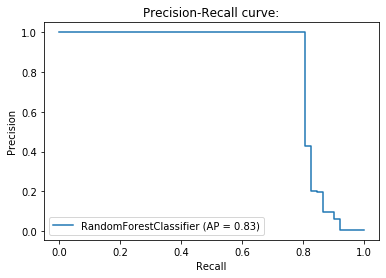

In [46]:
# Checking Precision and Recall
disp = plot_precision_recall_curve(rf, features_test, labels_test)
disp.ax_.set_title('Precision-Recall curve:')
plt.savefig("/content/drive/My Drive/SENSO_ASSIGNMENT/precision_recall_curve.png")